In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

# 1. Accessing the data

In [2]:
import glob

In [3]:
breast_img = glob.glob('archive/**/*.png',    # searches for all '*.png' files in 'archive' folder
                                              # **: matches any level of subdirectories
                       recursive = True)      # search for files not only in the specified directory but also in all its subdirectories

In [4]:
neg_img_path = list()
pos_img_path = list()

counter = 0

for img in breast_img:
    counter+=1
    if img[-10:-4] == 'class0':
        neg_img_path.append(img)
    elif img[-10:-4] == 'class1':
        pos_img_path.append(img)

In [5]:
# creating an random array of 16 pos & 16 neg indices for cancer images
neg_img_path_indices = np.random.randint(0, len(neg_img_path), 16) 
pos_img_path_indices = np.random.randint(0, len(pos_img_path), 16)
img_path_indices = np.concatenate((neg_img_path_indices, pos_img_path_indices))
np.random.shuffle(img_path_indices)                   # shuffles the order of the array

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
img = load_img((breast_img[5]))    # target_size=(100, 100))
img = img_to_array(img)
print('the images are stored in the form:', img.shape)

the images are stored in the form: (50, 50, 3)


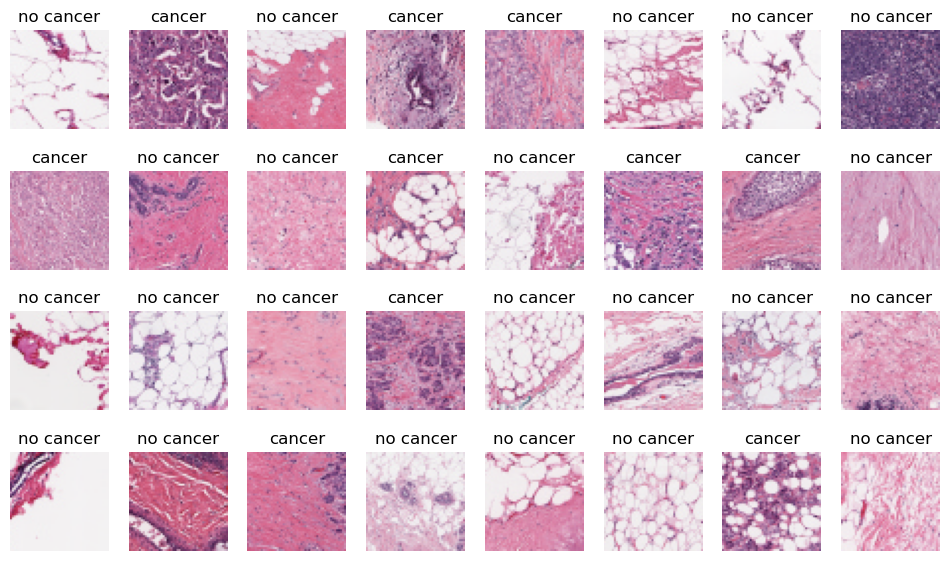

In [8]:
fig, axes = plt.subplots(4,8, figsize=(12,7))      

for i,ax in enumerate(axes.flat): 

    index = img_path_indices[i]
    img = load_img((breast_img[index]), target_size=(50, 50))
    img = img_to_array(img)

    if breast_img[index][-5] == '0':
        label = 'no cancer'
    else: label = 'cancer'

    ax.axis('off')
    ax.set_title(label)
    ax.imshow(img.astype('uint8'))
    

amount of negative cancer images: 397476
amount of positive cancer images: 157572


<function matplotlib.pyplot.show(close=None, block=None)>

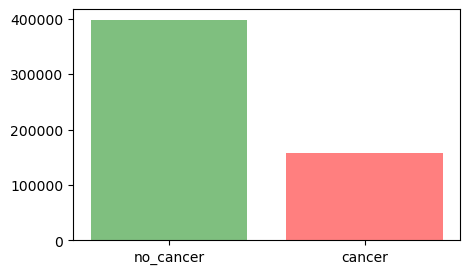

In [9]:
print('amount of negative cancer images:', len(neg_img_path))
print('amount of positive cancer images:', len(pos_img_path))

plt.figure(figsize=(5,3))
plt.bar(('no_cancer', 'cancer'), (len(neg_img_path), len(pos_img_path)), color=('green', 'red'), alpha=0.5)
plt.show

**the data set appears to be skewed!**

# 2. Preprocessing the data

### 2.1 Resizing the necessary images and creating a numpy dataset

In [10]:
import cv2
import random

In [11]:
ds = list()

for _ in neg_img_path:
        
    img = cv2.imread(_, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (50, 50),                     # !! because the images are not all of the same shape (50,50), resizing w needed
                            interpolation = cv2.INTER_LINEAR)   # !! Linear interpolation estimates pixel values by considering a weighted average of the surrounding pixels
    ds.append([img_resized, 0])
    
for _ in pos_img_path:
    
    img = cv2.imread(_, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (50, 50),                    
                            interpolation = cv2.INTER_LINEAR)
    ds.append([img_resized, 1])

In [12]:
seed = 420
random.seed(seed)  
random.shuffle(ds)

    
X = np.array([img for img, label in ds])
y = np.array([label for img, label in ds])

### 2.2 Creating a train-validation-split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3 Oversampling of the dataset

\# making copies of the minority set to even out the classes size

In [15]:
from tensorflow.keras.utils import Sequence                 # used for creating custom data generators
from imblearn.over_sampling import RandomOverSampler        # imbalanced learning
from imblearn.tensorflow import balanced_batch_generator    # creates balanced batches for training deep learning models in TensorFlow

In [16]:
def balanced_data_generator(X, y, batch_size):
    batch_size_fin = min(batch_size, X.shape[0])
    ds_gen, steps_per_epoch = balanced_batch_generator(X.reshape(X.shape[0], -1), y,     # !!! ndarray X of shape (n_samples, n_features)
                                                    sampler=RandomOverSampler(),
                                                    batch_size=batch_size_fin, keep_sparse=True)

    def ds_gen_to_np_converter(ds_gen, steps_per_epoch):
        X_train_list = list()
        y_train_list = list()
        counter = 0
        for imgs, lbls in ds_gen:
            X_train_list.append(imgs)
            y_train_list.append(lbls)
            counter += 1
            if counter > steps_per_epoch:                                            # !! if working with batches you NEED your steps_per_epoch for the for loop
                break
        
        X_train_new = list()
        for array in X_train_list:
            array = array.reshape((array.shape[0], 50, 50, 3))                           # !!! reverse reshaping because of balanced_batch_generator
            X_train_new.append(array)
            
        X_train_new = np.concatenate(X_train_new)
        y_train_new = np.concatenate(y_train_list)

        return X_train_new, y_train_new

    
    X_train_new, y_train_new = ds_gen_to_np_converter(ds_gen, steps_per_epoch)

    return X_train_new, y_train_new

X_train_new, y_train_new = balanced_data_generator(X_train, y_train, batch_size=32)  # !! for some reason the generator only functions properly with a batch_size=32


positive cancer images: 317871
negative cancer images: 317871


<BarContainer object of 2 artists>

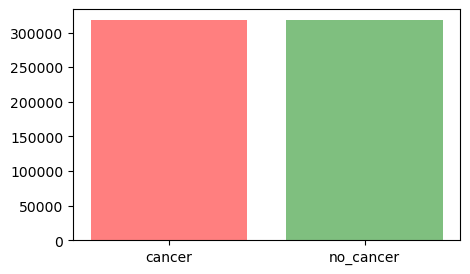

In [17]:
y_train_new_1 = y_train_new[y_train_new == 1]
y_train_new_0 = y_train_new[y_train_new == 0]

print('positive cancer images:', len(y_train_new_1))
print('negative cancer images:', len(y_train_new_0))

plt.figure(figsize=(5,3))
plt.bar(['cancer', 'no_cancer'], [len(y_train_new_1), len(y_train_new_0)], color=['red', 'green'], alpha=0.5)

### 2.3 Transformation of the data into tf.data.Dataset format !!!

In [18]:
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.shuffle(buffer_size=valid_ds.cardinality())
valid_ds = valid_ds.batch(32)

# create test set from splitting valid_ds
#valid_batches = tf.data.experimental.cardinality(valid_ds)
#test_dataset = valid_ds.take(valid_batches // 5)
#valid_ds = valid_ds.skip(val_batches // 5)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
train_ds = train_ds.shuffle(buffer_size=train_ds.cardinality())
train_ds = train_ds.batch(32)

Metal device set to: Apple M2


2024-01-26 13:46:43.455966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-26 13:46:43.456935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 2.4 Data augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2) #,
    #tf.keras.layers.RandomCrop(height=50, width=50)
])

### 2.5 Rescale Pixel Values

this project works with the pretrained model NASNetMobile and the model expects pixel values [-1, 1]

→ rescaling of the pixel value $i$ : $\frac i {(255:2)} - 1$



In [20]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# automatic rescaling
#rescale_auto = tf.keras.applications.nasnet.preprocess_input

# 3. CNN

### 3.1 Transfer learning (frozen model)

nice tutorial on transfer learning: https://www.tensorflow.org/tutorials/images/transfer_learning

In [21]:
from tensorflow.keras.applications.nasnet import NASNetMobile       # on my machine takes already about 20 minutes for fitting the model even with frozen layers → no use
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

**\# Import model for transfer learning**

In [22]:
base_model = MobileNetV2(
    weights='imagenet',          # Load weights pre-trained on ImageNet.
                                    # if None: random initialization
    input_shape=(50, 50, 3),
    include_top=False)           # Do not include the ImageNet classifier at the top -> is used only for the base

# freezing the model
base_model.trainable = False     # weights in layers of the convolutional base  can't be updated during training
                                    # freezes all of the trainable layers

x = **base_model**('*batch*')  has an output of the shape $(n, i, i, \#channels)$

**\# Create a new model on top**

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(units = 1)    # output of a single value

y = **GAP2D**(*x*) has an output of the shape $(n, \#channels)$
    
    → converts spatial-locations/2D-coordinates $(i, i)$ into a single $\#channels$-element vector per image
z = **Dense(1)**(*y*) has an output of the shape $(n, i)$

    → converts into a single prediction per image

### 3.2 Building the model

In [24]:
inputs = tf.keras.Input(shape=(50, 50, 3))
x = data_augmentation(inputs)
x = rescale(x)
# x = rescale_auto(x) # preprocess_input would have had the same effect as rescale

x = base_model(inputs,           # pre-trained 'base_model' is applied to the input tensor 'inputs' -> images are passed through the CNN/convolutional layer
               training=False)   # sets the model to inference mode -> no training!
                                    # Batch Normalization and Dropout layers will use the statistics (mean, variance, etc.) learned during training 
                                    # rather than updating them with the current batch of data
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 3.3 Compiling the model

since the model rovides a linear output: `from_logits = True`

In [25]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### 3.4 Training the frozen model

In [ ]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=valid_ds)

Epoch 1/10  
19867/19867 [==============================] - 438s 22ms/step - loss: 0.6799 - accuracy: 0.5271 - val_loss: 0.4207 - val_accuracy: 0.8258  
Epoch 2/10  
19867/19867 [==============================] - 440s 22ms/step - loss: 0.6714 - accuracy: 0.5296 - val_loss: 0.4263 - val_accuracy: 0.8236  
Epoch 3/10  
19867/19867 [==============================] - 443s 22ms/step - loss: 0.6707 - accuracy: 0.5293 - val_loss: 0.4126 - val_accuracy: 0.8270  
Epoch 4/10  
19867/19867 [==============================] - 443s 22ms/step - loss: 0.6706 - accuracy: 0.5303 - val_loss: 0.4416 - val_accuracy: 0.8149  
Epoch 5/10  
19867/19867 [==============================] - 445s 22ms/step - loss: 0.6705 - accuracy: 0.5297 - val_loss: 0.4124 - val_accuracy: 0.8273  
Epoch 6/10  
19867/19867 [==============================] - 441s 22ms/step - loss: 0.6705 - accuracy: 0.5292 - val_loss: 0.4206 - val_accuracy: 0.8243  
Epoch 7/10  
19867/19867 [==============================] - 441s 22ms/step - loss: 0.6703 - accuracy: 0.5293 - val_loss: 0.4052 - val_accuracy: 0.8300  
Epoch 8/10  
19867/19867 [==============================] - 441s 22ms/step - loss: 0.6701 - accuracy: 0.5294 - val_loss: 0.4552 - val_accuracy: 0.8122  
Epoch 9/10  
19867/19867 [==============================] - 440s 22ms/step - loss: 0.6702 - accuracy: 0.5293 - val_loss: 0.4105 - val_accuracy: 0.8288  
Epoch 10/10  
19867/19867 [==============================] - 442s 22ms/step - loss: 0.6701 - accuracy: 0.5312 - val_loss: 0.4688 - val_accuracy: 0.8030

In [26]:
# ploting loss & accuracy

def loss_acc_plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(epochs, loss, 'b', label='Training loss')
    ax1.plot(epochs, val_loss, 'r', label='Validation loss')
    ax1.set_title('Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.plot(epochs, accuracy, 'b', label='Training accuracy')
    ax2.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend()

    plt.show()


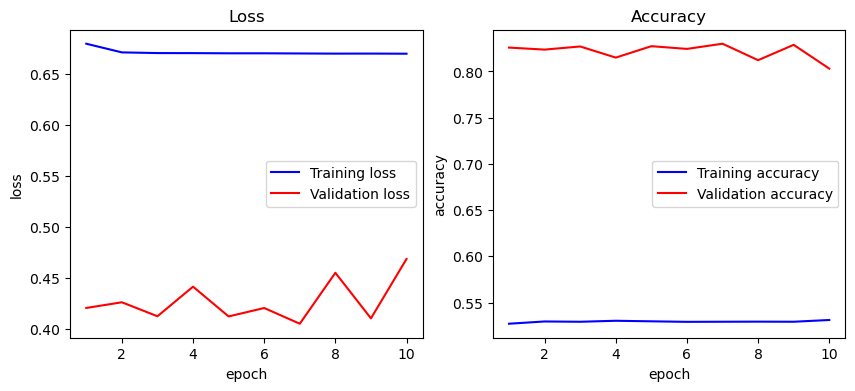

In [28]:
loss_acc_plot(history)

### 3.5 Unfreezing the top layers of the model

In [27]:
base_model.trainable = True

In [28]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [29]:
for layer in base_model.layers[:100]:      # fine tuning the last 54 layers
  layer.trainable = False

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
history_fine = model.fit(train_ds,
                         epochs=10,
                         #epochs=initial_epochs + 10,
                         #initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Epoch 1/10  
19867/19867 [==============================] - 1037s 52ms/step - loss: 0.7041 - accuracy: 0.5260 - val_loss: 0.4297 - val_accuracy: 0.8281  
Epoch 2/10  
19867/19867 [==============================] - 1096s 55ms/step - loss: 0.6852 - accuracy: 0.5268 - val_loss: 0.4239 - val_accuracy: 0.8301  
Epoch 3/10  
19867/19867 [==============================] - 1127s 57ms/step - loss: 0.6845 - accuracy: 0.5292 - val_loss: 0.4384 - val_accuracy: 0.8297  
Epoch 4/10  
19867/19867 [==============================] - 1112s 56ms/step - loss: 0.6828 - accuracy: 0.5291 - val_loss: 0.4468 - val_accuracy: 0.8290  
Epoch 5/10  
19867/19867 [==============================] - 1130s 57ms/step - loss: 0.6852 - accuracy: 0.5293 - val_loss: 0.4085 - val_accuracy: 0.8304  
Epoch 6/10  
19867/19867 [==============================] - 1145s 58ms/step - loss: 0.6887 - accuracy: 0.5279 - val_loss: 0.4137 - val_accuracy: 0.8371  
Epoch 7/10  
19867/19867 [==============================] - 1137s 57ms/step - loss: 0.6861 - accuracy: 0.5287 - val_loss: 0.4220 - val_accuracy: 0.8312  
Epoch 8/10  
19867/19867 [==============================] - 1139s 57ms/step - loss: 0.6827 - accuracy: 0.5292 - val_loss: 0.4508 - val_accuracy: 0.8170  
Epoch 9/10  
19867/19867 [==============================] - 1148s 58ms/step - loss: 0.6840 - accuracy: 0.5295 - val_loss: 0.4661 - val_accuracy: 0.8382  
Epoch 10/10  
19867/19867 [==============================] - 1158s 58ms/step - loss: 0.6842 - accuracy: 0.5294 - val_loss: 0.4257 - val_accuracy: 0.8257  

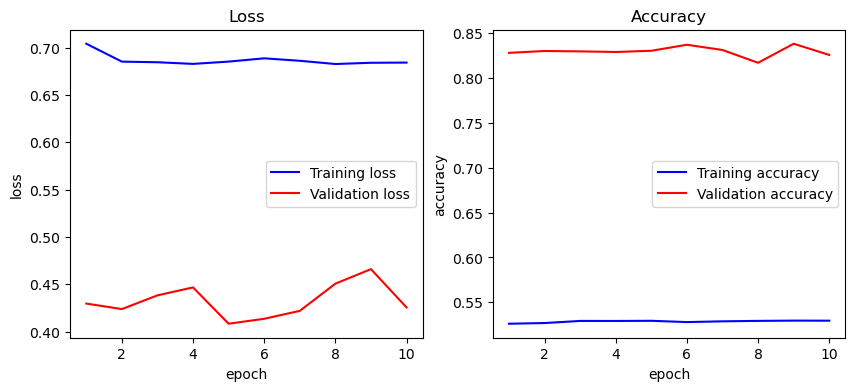

In [32]:
loss_acc_plot(history_fine)